# Putative disease gene identification and drug repurposing for 'Degenerative polyarthritis'

## Sharifeh Alaei - alaei.2050840@studenti.uniroma1.it

## Gizem Gokar - goker.2051419@studenti.uniroma1.it

## Nasim Sadeghi -Sadeghikhanshir.2056375@studenti.uniroma1.it

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import time
import networkx as nx
import numpy as np
import copy
import scipy.stats
from collections import defaultdict
import csv
import sys

In [ ]:
#from google.colab import drive

# Mount Google Drive
#drive.mount('/content/drive')

Mounted at /content/drive


## Part 1:PPI and GDA data gathering and interactome reconstruction

## part 1.1:Download PPIs from BioGRID latest release to build the human interactome

In [ ]:
#!unzip /content/drive/MyDrive/BioProject/Question1/BIOGRID-ORGANISM-4.4.229.tab3 -d /content/drive/MyDrive/BioProject/Question1

In [2]:
biogrid_path =  'BIOGRID-ORGANISM-Homo_sapiens-4.4.229.tab3.txt'
#biogrid_path =  '/content/drive/MyDrive/BioProject/Question1/BIOGRID-ORGANISM-Homo_sapiens-4.4.229.tab3.txt'
# Read the text file into a Pandas DataFrame
biogrid = pd.read_csv(biogrid_path, delimiter='\t')

C:\Users\m433\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,2,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
biogrid.head()

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,TREMBL Accessions Interactor B,REFSEQ Accessions Interactor B,Ontology Term IDs,Ontology Term Names,Ontology Term Categories,Ontology Term Qualifier IDs,Ontology Term Qualifier Names,Ontology Term Types,Organism Name Interactor A,Organism Name Interactor B
0,103,6416,2318,112315,108607,-,-,MAP2K4,FLNC,JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAP...,...,Q59H94,NP_001120959|NP_001449,-,-,-,-,-,-,Homo sapiens,Homo sapiens
1,117,84665,88,124185,106603,-,-,MYPN,ACTN2,CMD1DD|CMH22|MYOP|RCM4,...,Q59FD9|F6THM6,NP_001094|NP_001265272|NP_001265273,-,-,-,-,-,-,Homo sapiens,Homo sapiens
2,183,90,2339,106605,108625,-,-,ACVR1,FNTA,ACTRI|ACVR1A|ACVRLK2|ALK2|FOP|SKR1|TSRI,...,-,NP_002018,-,-,-,-,-,-,Homo sapiens,Homo sapiens
3,278,2624,5371,108894,111384,-,-,GATA2,PML,DCML|IMD21|MONOMAC|NFE1B,...,-,NP_150250|NP_150253|NP_150252|NP_150247|NP_150...,-,-,-,-,-,-,Homo sapiens,Homo sapiens
4,418,6118,6774,112038,112651,RP4-547C9.3,-,RPA2,STAT3,REPA2|RP-A p32|RP-A p34|RPA32,...,-,NP_644805|NP_003141|NP_001356447|NP_001356443|...,-,-,-,-,-,-,Homo sapiens,Homo sapiens


In [3]:
# Number of rows
biogrid.shape

(1203844, 37)

Filter out all non-human interactions, i.e., both “organism A” and “B” fields must be = **9606 (Homo sapiens)**

In [4]:
# Filter for Homo sapiens interactions
df = biogrid[(biogrid['Organism ID Interactor A'] == 9606) & (biogrid['Organism ID Interactor B'] == 9606)]

Keep only **“physical”** interactions” (“Experimental System Type” = physical)


In [5]:
df_1 = df[df['Experimental System Type'] == 'physical']

Purge out redundant and self loops

---


a) Eliminate redundant interactions where you may have multiple rows with the same pair of interacting proteins

b)Remove self-loops where "Interactor A" is the same as "Interactor B"


In [6]:
# Remove self-loops where "Interactor A" is the same as "Interactor B"
df_2 = df_1[df_1['BioGRID ID Interactor A'] != df_1['BioGRID ID Interactor B']]

In [7]:
# Remove duplicate rows
df_3 = df_2.drop_duplicates()

In [8]:
df_3.shape

(1093478, 37)

###Isolate the largest connected component (LCC)

In [12]:
# Assuming 'df_3' is our DataFrame after filtering steps

# Create a graph from the DataFrame
G = nx.from_pandas_edgelist(df_3, 'Official Symbol Interactor A','Official Symbol Interactor B')

# Find connected components
connected_components = list(nx.connected_components(G))

# Identify the largest connected component
largest_connected_component = max(connected_components, key=len)

# Extract the subgraph corresponding to the largest connected component
largest_connected_subgraph = G.subgraph(largest_connected_component)

print("Nodes in largest connected component:", largest_connected_subgraph.number_of_nodes())
print("Edges in largest connected component:", largest_connected_subgraph.number_of_edges())

Nodes in largest connected component: 19831
Edges in largest connected component: 822762


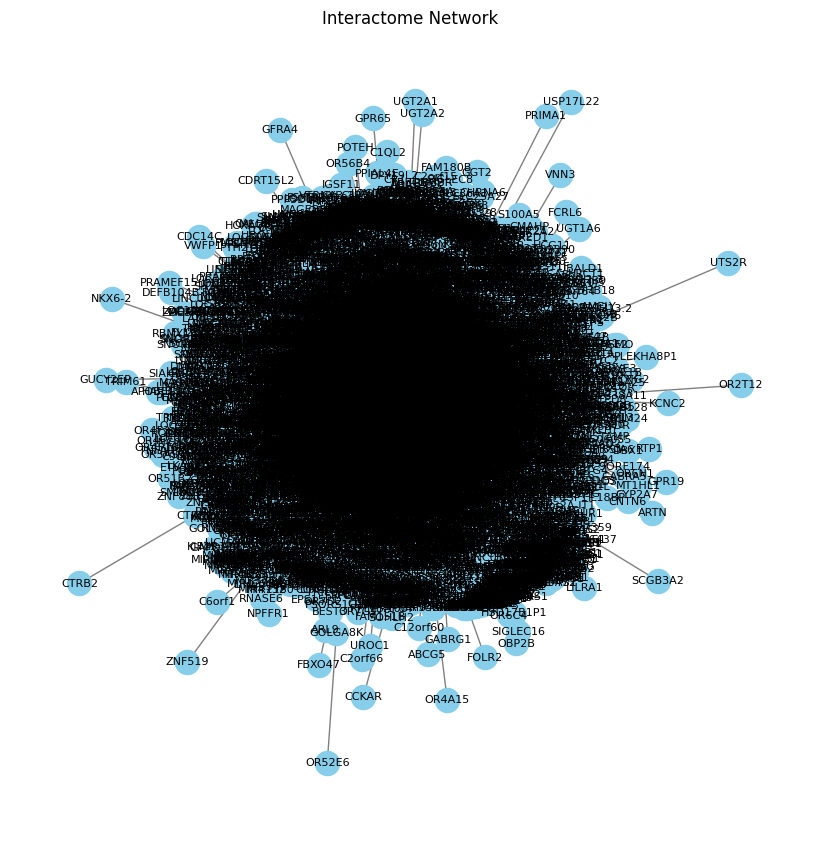

In [ ]:
#The interactome network
plt.figure(figsize=(8, 8))
nx.draw(G, with_labels=True, font_size=8, node_color='skyblue', edge_color='gray')
plt.title('Interactome Network')
plt.show()

## Part 1.2 - Gather gene-disease associations (GDAs) data from DisGeNET


In [9]:
# Gene-disease association data from DisGeNET

#gda_data_path = '/content/drive/MyDrive/BioProject/Question1/C0029408_disease_gda_summary_CURATED.xlsx'
#gda_data_path = '/content/drive/MyDrive/C0029408_disease_gda_summary_CURATED.xlsx'
gda_data_path = 'C0029408_disease_gda_summary_CURATED.xlsx'
gda_data = pd.read_excel(gda_data_path)

In [10]:
gda_data.head()

,Disease,Disease_id,Gene,Gene_id,UniProt,Gene_Full_Name,Protein_Class,N_diseases_g,DSI_g,DPI_g,pLI,Score_gda,EL_gda,EI_gda,N_PMIDs,N_SNPs_gda,First_Ref,Last_Ref
0,Degenerative polyarthritis,C0029408,COMP,1311.0,P49747,cartilage oligomeric matrix protein,NaN,9.0,0.503,0.808,1.346200e-09,0.50,NaN,0.971,1.0,0.0,1995.0,2019.0
1,Degenerative polyarthritis,C0029408,COL2A1,1280.0,P02458,collagen type II alpha 1 chain,NaN,71.0,0.444,0.846,1.000000e+00,0.50,NaN,0.941,2.0,1.0,1993.0,2020.0
2,Degenerative polyarthritis,C0029408,MATN3,4148.0,O15232,matrilin 3,Receptor,8.0,0.644,0.385,1.350000e-08,0.50,NaN,1.000,0.0,0.0,2002.0,2018.0
3,Degenerative polyarthritis,C0029408,TGFB1,7040.0,P01137,transforming growth factor beta 1,Signaling,179.0,0.287,0.962,3.685000e-02,0.50,NaN,1.000,1.0,1.0,2000.0,2020.0
4,Degenerative polyarthritis,C0029408,DPEP1,1800.0,P16444,dipeptidase 1,NaN,3.0,0.570,0.654,3.473000e-10,0.42,NaN,1.000,1.0,1.0,2017.0,2019.0


In [11]:
gda_data['Gene'].unique()

array(['COMP', 'COL2A1', 'MATN3', 'TGFB1', 'DPEP1', 'ALDH1A2', 'IL1B',
       'ASPN', 'RUNX2', 'SMAD3', 'GDF5', 'PPARG', 'FRZB', 'AGER', 'CTSK',
       'SOD2', 'FGF18', 'CALCA', 'TGM2', 'CHI3L1', 'TRPV4', 'CLU',
       'CXCL2', 'S100A4', 'SLC2A1', 'EDIL3', 'VIM', 'CXCL6', 'ENO1',
       'ACTB', 'PLOD2', 'BMP4', 'GSTK1', 'LTBP3', 'BMP6', 'COL1A2',
       'CTSD', 'AKR1C1', 'TRIM2', 'TFPI2', 'SDCBP', 'PSMB1', 'PPP2R1A',
       'MVP', 'TNFSF15', 'POU3F3', 'PLS3', 'SCRN1', 'RAN', 'SGCG',
       'MYH13', 'ISOC2', 'SDHA', 'EZR', 'VDAC2', 'TXNRD1', 'RCN3',
       'PLCD1', 'ETFA', 'ESD', 'AK4', 'EEF2', 'DPYSL2', 'PDCD6IP',
       'DDX3X', 'AKR1C2', 'COL6A2', 'CLIC1', 'IMMT', 'YWHAQ', 'P3H3',
       'SEC23A', 'ACAA2', 'ADGRG2', 'FTL', 'CLIC4', 'ATP6V1B2', 'PDHA1',
       'OPA1', 'NME2', 'ACO1', 'ATP1A3', 'NDUFS8', 'NDUFV1', 'MSN',
       'IDH3A', 'IDH2', 'HADHA', 'GLS', 'DAPP1', 'HIBCH', 'GAPDH',
       'TRAP1'], dtype=object)

In [12]:
gene_list = gda_data['Gene'].unique().tolist()

In [13]:
G_interactome = nx.from_pandas_edgelist(df_3, 'Official Symbol Interactor A','Official Symbol Interactor B')

In [14]:
G_disease_network = G_interactome.subgraph(gene_list)

In [15]:
lcc_disease_network = max(nx.connected_components(G_disease_network), key=len)

In [16]:
# Basic network measures for the disease network
num_nodes = len(lcc_disease_network)
num_edges = G_disease_network.subgraph(lcc_disease_network).number_of_edges()
avg_degree = sum(dict(G_disease_network.degree(lcc_disease_network)).values()) / num_nodes

print(f"Number of nodes in Disease LCC: {num_nodes}")
print(f"Number of edges in Disease LCC: {num_edges}")
print(f"Average degree in Disease LCC: {avg_degree}")

Number of nodes in Disease LCC: 65
Number of edges in Disease LCC: 176
Average degree in Disease LCC: 5.415384615384616


In [17]:
# Convert the set to a graph
lcc_disease_graph = nx.Graph()
lcc_disease_graph.add_nodes_from(lcc_disease_network)

In [18]:
lcc_disease_graph.add_edges_from(G_disease_network.subgraph(lcc_disease_network).edges)

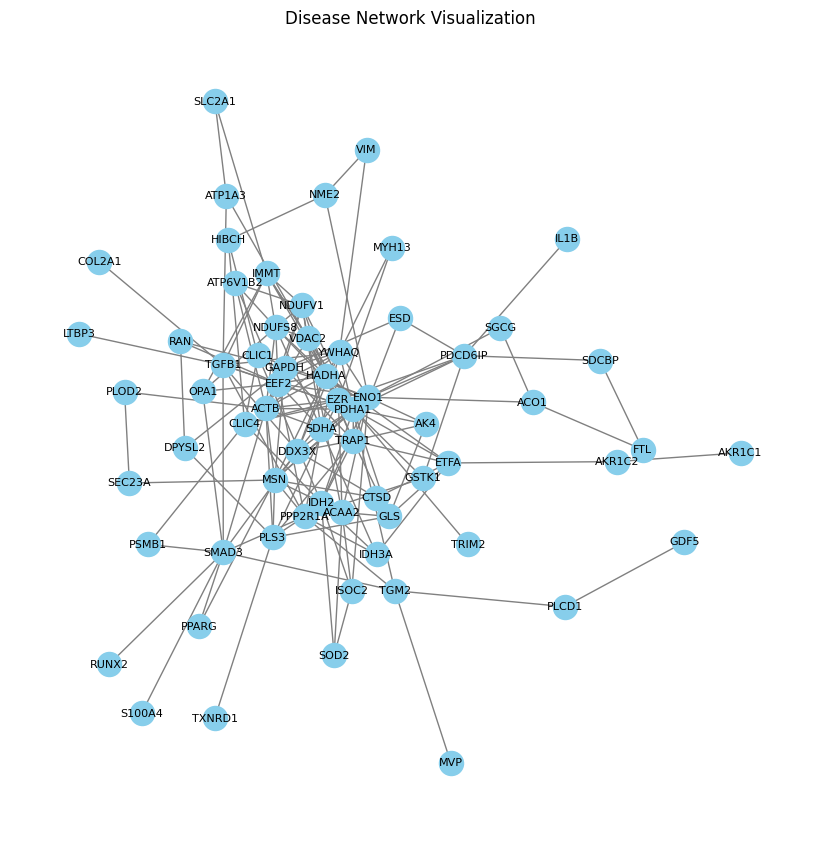

In [ ]:
plt.figure(figsize=(8, 8))
nx.draw(lcc_disease_graph, with_labels=True, font_size=8, node_color='skyblue', edge_color='gray')
plt.title('Disease Network Visualization')
plt.show()

## Part 1.3 - Compute and characterize the disease LCC and its basic network measures

 Summarize the GDA-related data as in table 1

In [19]:
Disease_Name = 'Degenerative polyarthritis'
UMLS_Disease_ID = 'C0029408'
MeSH_Disease_Class = 'Musculoskeletal Diseases'
Number_of_Associated_Genes = len(gene_list)
Number_of_Genes_Present_in_the_Interactome = len(G_disease_network)
LCC_Size_of_the_Disease_Interactome = len(lcc_disease_network)

In [20]:
T1 = {
    'Disease Name': [Disease_Name],
    'UMLS Disease ID': [UMLS_Disease_ID],
    'MeSH Disease Class': [MeSH_Disease_Class],
    'Number of Associated Genes': [Number_of_Associated_Genes],
    'Number of Genes Present in the Interactome': [Number_of_Genes_Present_in_the_Interactome],
    'LCC Size of the Disease Interactome': [LCC_Size_of_the_Disease_Interactome]}

# Creating a DataFrame from the dictionary
table1 = pd.DataFrame(T1)

In [21]:
table1

,Disease Name,UMLS Disease ID,MeSH Disease Class,Number of Associated Genes,Number of Genes Present in the Interactome,LCC Size of the Disease Interactome
0,Degenerative polyarthritis,C0029408,Musculoskeletal Diseases,93,91,65


Compute the following network metrics on the disease LCC:
Node degree
Betweenness centrality
Eigenvector centrality
Closeness centrality
ratio Betweenness/Node degree
Report in a table the above network measures of the first 50 disease genes in the disease LCC ordered for node degree from higher to lower, as in **table 2**


In [22]:
# Node degree (actual number of edges, not normalized)
degree = dict(lcc_disease_graph.degree())

# Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(lcc_disease_graph)

# Eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(lcc_disease_graph)

# Closeness centrality
closeness_centrality = nx.closeness_centrality(lcc_disease_graph)

# Calculate the ratio Betweenness/Node degree
ratio_betweenness_degree = {
    node: betweenness_centrality[node] / degree[node] if degree[node] != 0 else 0
    for node in lcc_disease_graph.nodes()
}

# Convert node degree dictionary to a sorted list of tuples
sorted_node_degrees = sorted(degree.items(), key=lambda x: x[1], reverse=True)

# Extract the top 50 genes based on node degree
top_50_genes = sorted_node_degrees[:50]

# Extract their network measures
top_50_data = []
for gene, degree_value in top_50_genes:
    gene_data = {
        'Gene': gene,
        'Node Degree': degree_value,
        'Betweenness Centrality': betweenness_centrality[gene],
        'Eigenvector Centrality': eigenvector_centrality.get(gene, 0),  # Some genes might not have eigenvector centrality
        'Closeness Centrality': closeness_centrality.get(gene, 0),
        'Ratio Betweenness/Degree': ratio_betweenness_degree[gene]
    }
    top_50_data.append(gene_data)

# Convert to DataFrame for easy viewing and analysis
top_50_df = pd.DataFrame(top_50_data)

In [23]:
top_50_df

,Gene,Node Degree,Betweenness Centrality,Eigenvector Centrality,Closeness Centrality,Ratio Betweenness/Degree
0,PDHA1,18,0.154391,0.338063,0.488550,0.008577
1,ENO1,16,0.205812,0.188753,0.481203,0.012863
2,ACTB,14,0.091179,0.286333,0.470588,0.006513
3,TRAP1,13,0.050396,0.244813,0.447552,0.003877
4,EEF2,13,0.070436,0.253674,0.470588,0.005418
5,HADHA,12,0.037828,0.286159,0.453901,0.003152
6,MSN,12,0.085482,0.205769,0.470588,0.007124
7,YWHAQ,11,0.112350,0.190291,0.470588,0.010214
8,VDAC2,10,0.030433,0.227884,0.421053,0.003043
9,SMAD3,10,0.109198,0.097555,0.418301,0.010920


Scatterplot of Node Degree and Node Betweenness

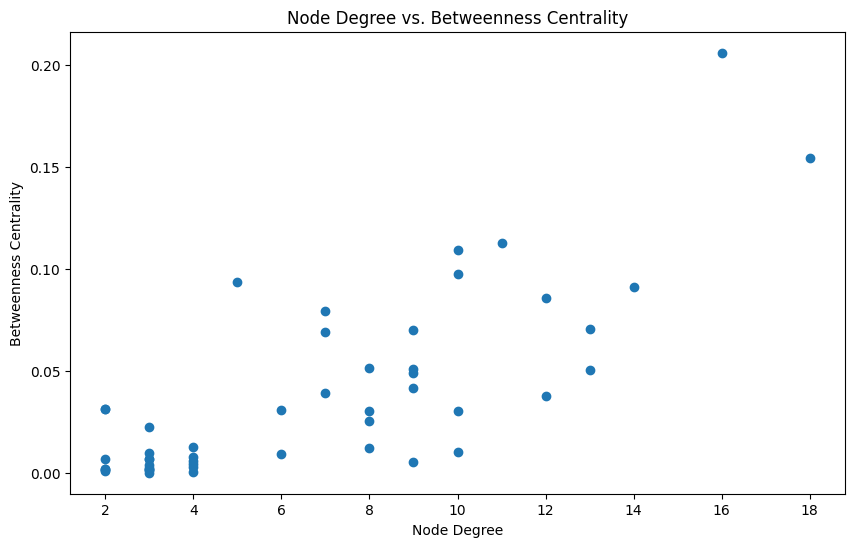

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(top_50_df['Node Degree'], top_50_df['Betweenness Centrality'])
plt.title('Node Degree vs. Betweenness Centrality')
plt.xlabel('Node Degree')
plt.ylabel('Betweenness Centrality')
plt.show()

In [ ]:
#https://chat.openai.com/share/7099d28d-01c6-479a-8fbd-98350e957aa5

## Part 2 - Comparative analysis of the disease genes identification algorithms

## Part 2.1 - Implementing Algorithm

### Diamond Algorithm

In [24]:
gda_data.Gene.to_csv("seed.txt", sep=",", index = False, header = False)
# Create the total ppi .txt and .tsv
totalPpi = df_3[["Official Symbol Interactor A" , "Official Symbol Interactor B"]]
totalPpi = totalPpi.rename(columns={'Official Symbol Interactor A': 'Gene1', 'Official Symbol Interactor B': 'Gene2'})
totalPpi.to_csv("totalPpi.tsv", sep="\t", index=False)
totalPpi.to_csv("totalppi.txt", sep=",", index=False,header=False)

In [25]:
# Assuming 'seed_genes' is your list of known disease genes and 'network' is your interactome network
# You may need to adjust these parameters according to your data format and the DIAMOnD documentation

!python  DIAMOnD.py  totalppi.txt  seed.txt  100 Disease_DIAMOND.txt
test = pd.read_csv("Disease_DIAMOND.txt", sep = '\t')
print(test.sort_values(by=['p_hyper']))


DIAMOnD(): ignoring 2 of 93 seed genes that are not in the network

 results have been saved to 'Disease_DIAMOND.txt' 

    #rank DIAMOnD_node       p_hyper
99    100       NDUFA2  3.533717e-49
98     99         TSFM  5.539513e-49
97     98       NDUFA7  6.941569e-48
96     97          AUH  7.705805e-47
95     96        TACO1  2.490346e-46
..    ...          ...           ...
5       6       UQCRC2  2.201841e-15
6       7       BCKDHA  4.466550e-15
2       3         EZH2  5.048111e-15
4       5       TRIM67  5.975131e-15
3       4          VCP  1.102426e-14

[100 rows x 3 columns]


### DiaBLE Algorithm

In [26]:
!python  DIABLE.py  totalppi.txt  seed.txt  100 Disease_DIABLE.txt
test = pd.read_csv("Disease_DIABLE.txt", sep = '\t')
print(test.sort_values(by=['p_hyper']))

DIAMOnD(): ignoring 2 of 93 seed genes that are not in the network

 results have been saved to 'Disease_DIABLE.txt' 

    #rank DIAMOnD_node       p_hyper
46     47        VDAC1  2.319099e-42
45     46       TOMM22  6.613976e-42
44     45         OGDH  4.742893e-41
40     41       NDUFS5  1.686875e-40
41     42        VDAC3  4.102833e-40
42     43       MYL12A  7.145635e-40
43     44          PHB  1.341389e-39
39     40        MTCH2  6.495236e-39
37     38       ATP5C1  1.450018e-38
47     48       NDUFA4  1.592978e-38
38     39       TOMM40  2.223988e-38
48     49       NDUFB9  1.140388e-37
36     37       NDUFA9  2.092491e-37
49     50      HSP90B1  2.879177e-37
35     36     NIPSNAP1  3.420182e-36
34     35       CORO1C  1.268603e-35
33     34       SCCPDH  2.050308e-34
31     32     ANKRD34C  5.098849e-34
32     33       NDUFS2  9.746281e-34
30     31        HADHB  1.639734e-32
29     30      COX7A2L  3.658228e-32
28     29         COX2  4.296044e-31
27     28       COX4I1  7.1542

### Diffusion-based Algorithm

In [ ]:

def propagate_network(network, initial_genes, diffusion_intervals):
    """
    Conducts a diffusion-based algorithm on the network over multiple intervals.

    Parameters:
    - network: NetworkX graph representing the interactome
    - initial_genes: List of initial genes associated with a condition
    - diffusion_intervals: List of intervals for diffusion (in arbitrary units)

    Returns:
    - results_genes_dict: Dictionary with intervals as keys and lists of resulting genes as values
    """
    results_genes_dict = {}

    for interval in diffusion_intervals:
        # Initialize propagation values for each node
        propagation_values = {node: 0.0 for node in network.nodes}

        # Set initial propagation values for initial genes
        for gene in initial_genes:
            propagation_values[gene] = 1.0

        iterations_count = int(interval * 1000)  # Modify multiplier for precision as needed
        for _ in range(iterations_count):
            next_propagation_values = propagation_values.copy()
            for node in network.nodes:
                adjacent_nodes = list(network.neighbors(node))
                if adjacent_nodes:
                    propagated_value = propagation_values[node] / len(adjacent_nodes)
                    for adjacent in adjacent_nodes:
                        next_propagation_values[adjacent] += propagated_value
            propagation_values = next_propagation_values

        # Determine resulting genes based on propagation values
        cutoff = np.percentile(list(propagation_values.values()), 95)  # Adjust threshold as necessary
        resulting_genes = [gene for gene, val in propagation_values.items() if val > cutoff]

        # Store resulting genes in the dictionary
        results_genes_dict[interval] = resulting_genes

    return results_genes_dict





In [ ]:
diffusion_intervals = [0.002, 0.005, 0.01]
initial_genes = gdaGen
network_graph = G_interactome
results_genes_dict = propagate_network(network_graph, initial_genes, [0.002, 0.005, 0.01])

# Display the resulting genes for each diffusion interval
for interval, resulting_genes in results_genes_dict.items():
    print(f"Resulting genes at diffusion interval {interval}: {resulting_genes}")

Resulting genes at diffusion interval 0.002: ['FLNC', 'ACVR1', 'FNTA', 'PML', 'RPA2', 'STAT3', 'ALDOA', 'APP', 'APPBP2', 'EP300', 'ARRB2', 'GRB2', 'BRCA1', 'TTN', 'CTNNB1', 'RB1', 'MCM2', 'RPA1', 'RPA3', 'MCM3', 'YWHAZ', 'CDC42', 'CDK2', 'CLTC', 'HGS', 'COL1A1', 'ATF2', 'SMAD3', 'PPIB', 'EGFR', 'FLNA', 'CREBBP', 'EEF1A1', 'ANXA5', 'ESR1', 'FGFR1', 'TGFB1', 'FTL', 'ITGB1', 'NR3C1', 'HSPA5', 'SDCBP', 'C1QBP', 'GANAB', 'HNRNPA1', 'PSMA3', 'HNRNPM', 'IMMT', 'SETD2', 'YWHAQ', 'YWHAE', 'KRT18', 'CBL', 'DNAJB6', 'LMNA', 'XRCC6', 'XRCC5', 'MBD1', 'MAP1B', 'SNCA', 'RELA', 'FOS', 'SNW1', 'NRAS', 'EZH2', 'RHOB', 'RHOA', 'PGD', 'MAPK1', 'AR', 'RHOG', 'RAB4A', 'RAB5A', 'RIN3', 'KRIT1', 'TRAP1', 'TOP3B', 'CLU', 'TFCP2', 'KAT5', 'NTRK1', 'HRAS', 'KRAS', 'SRC', 'TP53', 'WWOX', 'PSMD2', 'CDH1', 'ITGA4', 'VHL', 'TRIM28', 'RANBP9', 'USP11', 'LRP2', 'LRPPRC', 'SUV39H1', 'UBE3A', 'UBQLN2', 'CTBP2', 'XPO1', 'NUFIP1', 'MSN', 'RAN', 'NR2C2', 'RNF4', 'YAF2', 'PXN', 'CDKN2A', 'EPS8', 'IARS', 'GARS', 'HTRA2', 'B

## Part 2.2 Computational Validation

### DiAmOND

## Diamond Algorithm

In [29]:
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import subprocess

def execDIaMOND_algorithm(train_data, iteration):
    """
    Executes the DIAMOnD algorithm with the given training data and iteration.
    The function is expected to save the output to a file.
    """
    train_data.to_csv("seed.txt", sep=",", index=False, header=False)
    output_file = f"Disease_DIAMOND_fold{iteration}.txt"
    subprocess.run(["python", "DIAMOnD.py", "totalppi.txt", "seed.txt", "100", output_file])

def evaluate_performance(predicted, actual, top_k_values):
    """
    Evaluates and returns the performance metrics for the given predictions.
    """
    metrics = {'precision': [], 'recall': [], 'f1_score': []}
    for top_k in top_k_values:
        ##SH
        #print(f"top_k: {top_k}")
        top_predictions = set(predicted[:top_k])   
        #print("top_predicted_Count:",len(top_predictions))
        #print("len(SP)",len(actual))
        true_positives = top_predictions.intersection(actual)   #TP = |SP^ intersection SP|
        #print("true_positives_count:", len(true_positives))
        false_positives = top_predictions.difference(actual)    #FP = |SP^ minus SP|
        #print("false_positives_count:",len(false_positives))
        false_negatives = actual.difference(top_predictions)
        #print("false_negatives_count:",len(false_negatives))    #FN = |SP minus SP^|
        ##another solution for calculating TP,FP,FN
        #precision = len(true_positives) / len(top_predictions) if top_predictions else 0
        #recall = len(true_positives) / len(actual) if actual else 0
        #SH
        precision = len(true_positives) / (len(true_positives) + len(false_positives)) if (len(true_positives) + len(false_positives)) > 0 else 0
        recall = len(true_positives) / (len(true_positives) + len(false_negatives)) if (len(true_positives) + len(false_negatives)) > 0 else 0
        #Common
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['f1_score'].append(f1)
    return metrics

# Main execution starts here
# Assuming 'gda_df' is the DataFrame with known disease genes (GDAs)
disease_genes = np.array(gda_data['Gene'])  # Convert to NumPy array
num_genes = len(disease_genes)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
metrics = {'precision': [], 'recall': [], 'f1_score': []}

for i, (train_index, test_index) in enumerate(kf.split(disease_genes)):
    ST, SP = disease_genes[train_index], disease_genes[test_index]
    print("Fold: " , i)
    execDIaMOND_algorithm(pd.DataFrame(ST), i)
    predicted_genes = pd.read_csv(f"Disease_DIAMOND_fold{i}.txt", delimiter='\t')['DIAMOnD_node']

    top_k_values = [50, num_genes//10, num_genes//4, num_genes//2, num_genes]
    fold_metrics = evaluate_performance(predicted_genes, set(SP), top_k_values)

    for key in metrics:
        metrics[key].extend(fold_metrics[key])

# Calculating average and standard deviation for each metric
for metric in metrics:
    average = np.mean(metrics[metric])
    std_dev = np.std(metrics[metric])
    print(f"Average {metric.capitalize()}: {average:.2f} ± {std_dev:.2f}")

# Print all metrics for each k-fold and top_k values
for metric in metrics:
    print(f"All {metric} for k = 1:5 and top_k = 50, n/10, n/4, n/2, n are:")
    print(metrics[metric])


Average Precision: 0.02 ± 0.02
Average Recall: 0.03 ± 0.03
Average F1_score: 0.02 ± 0.02
All precision for k = 1:5 and top_k = 50, n/10, n/4, n/2, n are:
[0.02, 0.0, 0.043478260869565216, 0.021739130434782608, 0.010752688172043012, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.043478260869565216, 0.021739130434782608, 0.021505376344086023, 0.02, 0.1111111111111111, 0.043478260869565216, 0.021739130434782608, 0.021505376344086023]
All recall for k = 1:5 and top_k = 50, n/10, n/4, n/2, n are:
[0.05263157894736842, 0.0, 0.05263157894736842, 0.05263157894736842, 0.05263157894736842, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05555555555555555, 0.0, 0.05555555555555555, 0.05555555555555555, 0.1111111111111111, 0.05555555555555555, 0.05555555555555555, 0.05555555555555555, 0.05555555555555555, 0.1111111111111111]
All f1_score for k = 1:5 and top_k = 50, n/10, n/4, n/2, n are:
[0.028985507246376812, 0, 0.04761904761904762, 0.03076923076923077, 0.017857142857142856, 0

### DiaBLE Algorithm

In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import os
import subprocess

def execDiAble_algorithm(training_genes, iteration, output_file):
    """
    Executes the algorithm script with the given training data and iteration.
    Outputs the results to a specified file.
    """
    # Save training genes to a file
    training_genes.to_csv("seed.txt", sep=",", index=False, header=False)
    # Construct command for running the algorithm script
    command = ["python", "DIABLE.py", "totalppi.txt", "seed.txt", "100", output_file]
    subprocess.run(command)

#def calculate_performance_metrics(predicted_genes, actual):
def calculate_performance_metrics(predicted, actual):    
    """
    Calculates precision, recall, and F1 score for the predicted genes against the test set.
    """
    precision_scores = []
    recall_scores = []
    f1_scores = []

    evaluation_points = [50, int(len(actual) / 10), int(len(actual) / 4), int(len(actual) / 2), len(actual)]
    
    for top_k in evaluation_points:
        top_predictions = set(predicted_genes[:top_k])
        true_positives = top_predictions.intersection(actual)
        ##SH
        #print(f"top_k: {top_k}")
        #print("top_predicted_Count:",len(top_predictions))
        #print("len(SP)",len(actual))
        true_positives = top_predictions.intersection(actual)
        #print("true_positives_count:", len(true_positives))
        false_positives = top_predictions.difference(actual)
        #print("false_positives_count:",len(false_positives))
        false_negatives = actual.difference(top_predictions)
        #print("false_negatives_count:",len(false_negatives))
        #another solution for calculation TP,FP,FN
        #precision = len(true_positives) / len(top_predictions) if top_predictions else 0
        #recall = len(true_positives) / len(actual) if actual else 0
        #SH
        precision = len(true_positives) / (len(true_positives) + len(false_positives)) if (len(true_positives) + len(false_positives)) > 0 else 0
        recall = len(true_positives) / (len(true_positives) + len(false_negatives)) if (len(true_positives) + len(false_negatives)) > 0 else 0
        #Common
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    return precision_scores, recall_scores, f1_scores

# Main script
disease_genes = np.array(gda_data['Gene'])
kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_precisions, all_recalls, all_f1_scores = [], [], []

for i, (train_index, test_index) in enumerate(kf.split(disease_genes)):
    training_set, test_set = disease_genes[train_index], disease_genes[test_index]

    output_filename = f"Disease_DIABLE_fold{i}.txt"
    print("Fold: " , i)
    execDiAble_algorithm(pd.DataFrame(training_set), i, output_filename)

    predicted_genes = pd.read_csv(output_filename, delimiter='\t')['DIAMOnD_node']
    precisions, recalls, f1s = calculate_performance_metrics(predicted_genes, set(test_set))

    all_precisions.extend(precisions)
    all_recalls.extend(recalls)
    all_f1_scores.extend(f1s)

# Calculate and print average and standard deviation for each metric
for metric_name, metric_values in zip(['Precision', 'Recall', 'F1 Score'], [all_precisions, all_recalls, all_f1_scores]):
    avg = np.mean(metric_values)
    sd = np.std(metric_values)
    print(f"Average {metric_name}: {avg:.2f} ± {sd:.2f}")

# Print all metrics for each k-fold and evaluation points
print("All precisions:", all_precisions)
print("All recalls:", all_recalls)
print("All F1 scores:", all_f1_scores)


Fold:  0
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Average Precision: 0.01 ± 0.02
Average Recall: 0.01 ± 0.02
Average F1 Score: 0.01 ± 0.02
All precisions: [0.02, 0.0, 0.0, 0.0, 0.05263157894736842, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0, 0.0, 0.05555555555555555, 0.0, 0.0, 0.0, 0.0, 0.0]
All recalls: [0.05263157894736842, 0.0, 0.0, 0.0, 0.05263157894736842, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05555555555555555, 0.0, 0.0, 0.0, 0.05555555555555555, 0.0, 0.0, 0.0, 0.0, 0.0]
All F1 scores: [0.028985507246376812, 0, 0, 0, 0.05263157894736842, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.029411764705882353, 0, 0, 0, 0.05555555555555555, 0, 0, 0, 0, 0]


### Cytoscape

Importing the data of Cytoscape application

In [ ]:
data_002_path =  '/content/drive/MyDrive/BioProject/Question 2/mainGraph_0.002.csv'
data_005_path =  '/content/drive/MyDrive/BioProject/Question 2/mainGraph_0.005.csv'
data_01_path =   '/content/drive/MyDrive/BioProject/Question 2/mainGraph_0.01.csv'

data_002 = pd.read_csv(data_002_path, delimiter=',')
data_005 = pd.read_csv(data_005_path, delimiter=',')
data_01 = pd.read_csv(data_01_path, delimiter=',')

In [ ]:
data_002.head()

,diffusion_input,diffusion_output_heat,diffusion_output_rank,name,selected,shared name
0,1.0,1.0,19750,OR2T12,False,OR2T12
1,1.0,1.0,19749,POTEH,False,POTEH
2,1.0,1.0,19748,SPDYE3,False,SPDYE3
3,1.0,1.0,19747,VNN3,False,VNN3
4,1.0,1.0,19746,LOC100996747,False,LOC100996747


In [ ]:
data_005.head()

,diffusion_input,diffusion_output_heat,diffusion_output_rank,name,selected,shared name
0,1.0,1.0,19830,MAP2K4,False,MAP2K4
1,1.0,1.0,2545,FLNC,False,FLNC
2,1.0,1.0,19829,MYPN,False,MYPN
3,1.0,1.0,19828,ACTN2,False,ACTN2
4,1.0,1.0,19827,ACVR1,False,ACVR1


In [ ]:
data_01.head()

,diffusion_input,diffusion_output_heat,diffusion_output_rank,name,selected,shared name
0,1.0,1.0,19161,MAP2K4,False,MAP2K4
1,1.0,1.0,9919,FLNC,False,FLNC
2,1.0,1.0,16694,MYPN,False,MYPN
3,1.0,1.0,16693,ACTN2,False,ACTN2
4,1.0,1.0,16692,ACVR1,False,ACVR1


In [ ]:
from sklearn.model_selection import KFold

# Sorting dataframes by gene ranking
df1_sorted = data_01.sort_values(by = ['diffusion_output_rank'], ascending = False)
df2_sorted = data_002.sort_values(by = ['diffusion_output_rank'], ascending = False)
df5_sorted = data_005.sort_values(by = ['diffusion_output_rank'], ascending = False)

# Initialize KFold cross-validator
kf = KFold(n_splits = 5)
# Assuming S0 is gene_intersection, i.e. the array of disease genes
n = len(gdaGen)
# Array of X top positions to consider
X_values = [50, round(1/10 * n), round(1/4 * n), round(1/2 *n), n]

def cross_validation_Diffusion(df_sorted, X_values = X_values):
   

    for X in X_values:

        precisions = []
        recalls = []
        f1_scores = []
        fold = 1
        print(f"Selecting the top {X} positions:")
        added_genes = df_sorted[:X]

        for train_index, test_index in kf.split(list(gdaGen)):

            ST = [gdaGen[i] for i in train_index]  # Training set (not really needed here)
            SP = [gdaGen[i] for i in test_index]   # Probe set
            # TP = size of the intersection between the gene in the top X positions and SP
            TP = [is_correctly_identified(gene, SP) for gene in added_genes].count(True)
            # FP = number of genes in the top X positions not present in SP
            FP = [is_correctly_identified(gene, SP) for gene in added_genes].count(False)
            # FN = number of genes in SP not present in the top X positions
            FN = [is_correctly_identified(gene, added_genes) for gene in SP].count(False)
            precision = TP / (TP + FP)
            recall = TP / (TP + FN)
            if (precision + recall == 0):
                f1 = 0
            else:
                f1 = (2 * precision * recall) / (precision + recall)

            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)

        print("Precision values =", precisions,
              " Mean =", round(np.mean(precisions), 2), " Std. dev. =", round(np.std(precisions)))
        print("Recall values    =", recalls,
              " Mean =", round(np.mean(recalls), 2), " Std. dev. =", round(np.std(recalls)))
        print("F1 scores        =", f1_scores,
              " Mean =", round(np.mean(f1_scores), 2), " Std. dev. =", round(np.std(f1_scores)))
        print()

    return

print("\n----- Diffusion Algorithm with t = 0.01 -----\n")
cross_validation_Diffusion(df1_sorted)

print("\n----- Diffusion Algorithm with t = 0.002 -----\n")
cross_validation_Diffusion(df2_sorted)

print("\n----- Diffusion Algorithm with t = 0.005 -----\n")
cross_validation_Diffusion(df5_sorted)


----- Diffusion Algorithm with t = 0.01 -----

Selecting the top 50 positions:
Precision values = [0.0, 0.0, 0.0, 0.0, 0.0]  Mean = 0.0  Std. dev. = 0
Recall values    = [0.0, 0.0, 0.0, 0.0, 0.0]  Mean = 0.0  Std. dev. = 0
F1 scores        = [0, 0, 0, 0, 0]  Mean = 0.0  Std. dev. = 0

Selecting the top 9 positions:
Precision values = [0.0, 0.0, 0.0, 0.0, 0.0]  Mean = 0.0  Std. dev. = 0
Recall values    = [0.0, 0.0, 0.0, 0.0, 0.0]  Mean = 0.0  Std. dev. = 0
F1 scores        = [0, 0, 0, 0, 0]  Mean = 0.0  Std. dev. = 0

Selecting the top 23 positions:
Precision values = [0.0, 0.0, 0.0, 0.0, 0.0]  Mean = 0.0  Std. dev. = 0
Recall values    = [0.0, 0.0, 0.0, 0.0, 0.0]  Mean = 0.0  Std. dev. = 0
F1 scores        = [0, 0, 0, 0, 0]  Mean = 0.0  Std. dev. = 0

Selecting the top 46 positions:
Precision values = [0.0, 0.0, 0.0, 0.0, 0.0]  Mean = 0.0  Std. dev. = 0
Recall values    = [0.0, 0.0, 0.0, 0.0, 0.0]  Mean = 0.0  Std. dev. = 0
F1 scores        = [0, 0, 0, 0, 0]  Mean = 0.0  Std. dev. = 

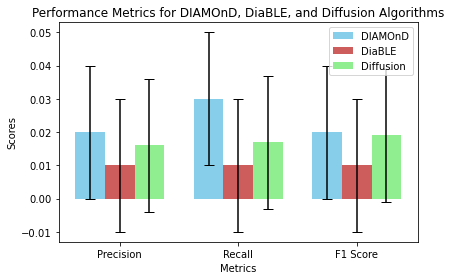

In [30]:

# Define the data for the algorithms' performance metrics
metrics = ['Precision', 'Recall', 'F1 Score']
diamond_scores = [0.02, 0.03, 0.02]
diABLE_scores = [0.01, 0.01, 0.01]
diffusion_scores = [0.016, 0.017, 0.019]
error = [0.02, 0.02, 0.02]  # Using DIAMOnD's std as a placeholder

# Define the x locations for the groups
ind = np.arange(len(metrics))
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

# Plotting data for DIAMOnD
rects1 = ax.bar(ind - width, diamond_scores, width, yerr=error, label='DIAMOnD', capsize=5, color='SkyBlue')

# Plotting data for DiaBLE
rects2 = ax.bar(ind, diABLE_scores, width, yerr=error, label='DiaBLE', capsize=5, color='IndianRed')

# Plotting data for Diffusion
rects3 = ax.bar(ind + width, diffusion_scores, width, yerr=error, label='Diffusion', capsize=5, color='LightGreen')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics for DIAMOnD, DiaBLE, and Diffusion Algorithms')
ax.set_xticks(ind)
ax.set_xticklabels(metrics)
ax.legend()

fig.tight_layout()

# Save the plot as a file
#fig.savefig('/mnt/data/algorithm_performance_comparison_with_diffusion.png')

# Show the plot
plt.show()


# Question 3.Putative disease gene identification





### 3.1. select the best performing algorithm and apply the process to predict new putative disease genes using all known GDAs as seed genes

In [29]:
def best_performing_algorithm(seed_genes):
    # Run your algorithm here and return the predicted genes
    # For example: return diamond.run_diamond(network, training_set, ...)
    df = pd.DataFrame(seed_genes)
    df.to_csv("seed.txt", sep=",", index=False,header=False)
    !python  DIAMOnD.py  totalppi.txt  seed.txt  100 output_best
   

# Assuming 'all_known_gdas' is your list of all known GDAs

seed_genes = np.array(gda_data.Gene)
# Run the algorithm
predicted_putative_genes = best_performing_algorithm(seed_genes)
df = pd.read_csv("output_best", sep = '\t')
top_gene = df.DIAMOnD_node
top_gene.to_csv("putative_disease_genes.txt", sep=",", index=False,header=False)
print("Top 100 putative disease genes have been identified and saved.")

DIAMOnD(): ignoring 2 of 93 seed genes that are not in the network

 results have been saved to 'output_best' 

Top 100 putative disease genes have been identified and saved.


### obtain a list of 100 putative disease genes

In [28]:
# Reading the results from the algorithm's output
df = pd.read_csv("output_best", sep='\t')

# Assuming 'DIAMOnD_node' column has the predicted genes, extract them
top_genes = df['DIAMOnD_node'].head(100)  # Get the top 100 genes

# Saving the top 100 genes to a CSV file
top_genes.to_csv("top_100_putative_disease_genes.csv", index=False, header=False)

# Printing the top 100 genes
print("Top 100 putative disease genes have been identified and saved:")
print(top_genes.tolist())


Top 100 putative disease genes have been identified and saved:
['PINK1', 'AGR2', 'EZH2', 'VCP', 'TRIM67', 'UQCRC2', 'BCKDHA', 'CPT1A', 'UQCRC1', 'CYC1', 'COX7C', 'NDUFA8', 'NNT', 'EMC2', 'NDUFS3', 'NDUFS1', 'NDUFS7', 'ATP5B', 'ZNF782', 'TOMM5', 'PHB2', 'COX7A2', 'C20orf24', 'ATP6V1A', 'UQCRQ', 'COA3', 'PDHB', 'COX4I1', 'COX2', 'COX7A2L', 'HADHB', 'ANKRD34C', 'NDUFS2', 'SCCPDH', 'CORO1C', 'NIPSNAP1', 'NDUFA9', 'ATP5C1', 'TOMM40', 'MTCH2', 'NDUFS5', 'VDAC3', 'MYL12A', 'PHB', 'OGDH', 'TOMM22', 'VDAC1', 'NDUFA4', 'NDUFB9', 'HSP90B1', 'APOE', 'CANX', 'COX5A', 'MGST3', 'COX6C', 'SFXN1', 'NDUFB10', 'LRPPRC', 'UQCRH', 'POR', 'NDUFB8', 'MINOS1', 'NDUFV2', 'P4HA1', 'AGPS', 'SURF1', 'LACTB', 'HMOX2', 'TUFM', 'PCCB', 'LONP1', 'ARMCX3', 'ATP5O', 'CCDC90B', 'ACAD9', 'NDUFS4', 'COX15', 'ATP5F1', 'ATP5H', 'MCUR1', 'NDUFA12', 'NDUFA5', 'C21orf33', 'CS', 'MDH2', 'TMEM70', 'NDUFS6', 'HINT2', 'TFAM', 'ICT1', 'NDUFA6', 'CCDC109B', 'MTIF2', 'C17orf80', 'NDUFV3', 'TACO1', 'AUH', 'NDUFA7', 'TSFM', 'NDUFA2']


### 3.2.	Enrichment analysis

■	Perform the enrichment analysis (via EnrichR: GO BP, MF, CC, and KEGG pathways) ***over the putative disease genes ***
result in report

■	Perform the enrichment analysis (via EnrichR: GO BP, MF, CC, and KEGG pathways) ***for the original disease genes gathered at point 1.2**
result in report